In [1]:
!git clone https://github.com/opendp/smartnoise-sdk

Cloning into 'smartnoise-sdk'...
remote: Enumerating objects: 6491, done.
remote: Counting objects: 100% (1789/1789), done.
remote: Compressing objects: 100% (1072/1072), done.
remote: Total 6491 (delta 886), reused 1379 (delta 624), pack-reused 4702
Receiving objects: 100% (6491/6491), 47.68 MiB | 18.29 MiB/s, done.
Resolving deltas: 100% (3694/3694), done.


Check smartnoise-sdk is downloaded

In [13]:
!ls

sample_data  smartnoise-sdk


Go into the folder that setup.py located

In [14]:
cd smartnoise-sdk/synth

/content/smartnoise-sdk/synth


In [15]:
!ls

build			  HISTORY.md	  README.md		     snsynth
COMPAS_fairness_mwem.npy  Makefile	  setup.py		     tests
dist			  pyproject.toml  smartnoise_synth.egg-info


In [5]:
!python setup.py build

running build
running build_py
creating build
creating build/lib
creating build/lib/snsynth
copying snsynth/quail.py -> build/lib/snsynth
copying snsynth/__init__.py -> build/lib/snsynth
copying snsynth/base.py -> build/lib/snsynth
copying snsynth/mwem.py -> build/lib/snsynth
creating build/lib/snsynth/models
copying snsynth/models/linear_regression.py -> build/lib/snsynth/models
copying snsynth/models/dp_covariance.py -> build/lib/snsynth/models
copying snsynth/models/__init__.py -> build/lib/snsynth/models
creating build/lib/snsynth/preprocessors
copying snsynth/preprocessors/preprocessing.py -> build/lib/snsynth/preprocessors
copying snsynth/preprocessors/__init__.py -> build/lib/snsynth/preprocessors
creating build/lib/snsynth/pytorch
copying snsynth/pytorch/pytorch_synthesizer.py -> build/lib/snsynth/pytorch
copying snsynth/pytorch/__init__.py -> build/lib/snsynth/pytorch
creating build/lib/snsynth/pytorch/nn
copying snsynth/pytorch/nn/privacy_utils.py -> build/lib/snsynth/pytorch

In [6]:
!python setup.py install

running install
running bdist_egg
running egg_info
creating smartnoise_synth.egg-info
writing smartnoise_synth.egg-info/PKG-INFO
writing dependency_links to smartnoise_synth.egg-info/dependency_links.txt
writing requirements to smartnoise_synth.egg-info/requires.txt
writing top-level names to smartnoise_synth.egg-info/top_level.txt
writing manifest file 'smartnoise_synth.egg-info/SOURCES.txt'
writing manifest file 'smartnoise_synth.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/snsynth
creating build/bdist.linux-x86_64/egg/snsynth/pytorch
copying build/lib/snsynth/pytorch/pytorch_synthesizer.py -> build/bdist.linux-x86_64/egg/snsynth/pytorch
creating build/bdist.linux-x86_64/egg/snsynth/pytorch/nn
copying build/lib/snsynth/pytorch/nn/privacy_utils.py -> build/bdist.linux-x86_64/egg/snsynth/pytorch/nn
copying bu

# install diffprivlib and restart runtime, and run the cells below 

In [27]:
! pip install diffprivlib.  


     |████████████████████████████████| 87 kB 2.9 MB/s 
     |████████████████████████████████| 23.1 MB 1.6 MB/s 
     |████████████████████████████████| 28.5 MB 48 kB/s 
  Created wheel for diffprivlib: filename=diffprivlib-0.5.0-py3-none-any.whl size=162302 sha256=ca6dfce0669d4bce6fadd32c06d145b0d885882457dacd07b95c7a1f6d432b25
  Stored in directory: /root/.cache/pip/wheels/e3/06/66/53eecc576e61a914f03ad5caee627823eb857225cb84aeb6d2
Successfully built diffprivlib
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentat

Now we are able to import the synthesizer. Also, due to the previous `cd smartnoise-sdk/synth` command, our jupyter notebook is inside smartnoise-sdk/synth so importing `snsynth` shall not run into any problem!

In [1]:
import numpy as np
import pandas as pd
import time
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from snsynth.mwem import MWEMSynthesizer

import warnings
from snsynth import QUAILSynthesizer
from snsynth.pytorch import PytorchDPSynthesizer
from diffprivlib.models import LogisticRegression as DPLR
warnings.filterwarnings("ignore")

In [2]:
def process_COMPAS(temp_df):
    """
    Pick columns = ['age_cat','priors_count','sex_numeric','juv_fel_count', 'juv_misd_count', 
    'juv_other_count', 'length_of_stay','race','two_year_recid', 'c_charge_degree', 
    'c_charge_desc'] from the dataframe. Convert category data into numeric and remove races 
    other than Caucasian or African-American. 
    
    Input: COMPAS dataframe
    Output: 
           COMPAS dataframe after cleaning
    """
    # deepcopy
    df = temp_df.copy()
    
    # remove invalid/null entries
    df = df[(df['days_b_screening_arrest'] <= 30)
                & (df['days_b_screening_arrest'] >= -30)
                & (df['is_recid'] != -1)
                & (df['c_charge_degree'] != 'O')
                & (df['score_text'] != 'N/A')]
    # remove races other than Caucasian or African-American
    df = df[(df['race']=='Caucasian') | (df['race']=='African-American')]

    # calculate length_of_stay
    df['c_jail_out'] = pd.to_datetime(df['c_jail_out'])
    df['c_jail_in'] = pd.to_datetime(df['c_jail_in'])
    # the number of seconds to the unix epoch start
    df['length_of_stay'] = (df['c_jail_out'] - df['c_jail_in']).astype(int) / 10**9 
    # convert seconds into month
    df['length_of_stay'] /= 60 * 60 * 24 * 31
    df['length_of_stay'] = df['length_of_stay'].astype(int)
    df = df.drop_duplicates()

    # convert category data into numeric
    df['sex_numeric'] = pd.factorize(df['sex'])[0]
    df['c_charge_degree_numeric'] = pd.factorize(df['c_charge_degree'])[0]
    race = {0: 'Caucasian', 1: 'African-American'}
    df["race"] = df["race"].map({v: k for k, v in race.items()})
    age = {1: 'Greater than 45', 0: '25 - 45', -1: 'Less than 25'}
    df["age_cat"] = df["age_cat"].map({v: k for k, v in age.items()})

    cols = ['age_cat','priors_count','sex_numeric','juv_fel_count', 'juv_misd_count', 'juv_other_count', 'c_charge_degree_numeric', 'length_of_stay','race','two_year_recid']
    df = df[cols]
    
    return df

In [3]:
def logisticRegression(x_train, y_train, x_test):
    from sklearn.linear_model import LogisticRegression

    logisticRegr = LogisticRegression(solver='lbfgs', max_iter=500)
    logisticRegr.fit(x_train, y_train)

    train_predictions = logisticRegr.predict(x_train)
    test_predictions = logisticRegr.predict(x_test)
    return train_predictions, test_predictions

In [4]:
def predictionSummary(temp_x, y_real, y_predict, df):
    tn, fp, fn, tp = confusion_matrix(y_real, y_predict, labels=[0, 1]).ravel()
    # False Positive, False Negative, True Positive, True Negative, Overall Accuracy
    overall = [fp/(fp+tn),fn/(fn+tp),tp/(tp+fn),tn/(tn+fp),(tp+tn)/y_real.shape[0]]

    x = temp_x.copy()
    x['medium_or_high_risk'] = y_predict
    x['two_year_recid'] = y_real
    
    # African-American
    x_black = x[df['race']==1].copy()
    tn, fp, fn, tp = confusion_matrix(x_black['two_year_recid'], x_black['medium_or_high_risk'], labels=[0, 1]).ravel()
    black = [fp/(fp+tn),fn/(fn+tp),tp/(tp+fn),tn/(tn+fp),(tp+tn)/(tp+fp+fn+tn)]

    # Caucasian
    x_white = x[df['race']==0].copy()
    tn, fp, fn, tp = confusion_matrix(x_white['two_year_recid'], x_white['medium_or_high_risk'], labels=[0, 1]).ravel()
    white = [fp/(fp+tn),fn/(fn+tp),tp/(tp+fn),tn/(tn+fp),(tp+tn)/(tp+fp+fn+tn)]

    return overall, black, white

In [44]:
def get_quail_synthesizer(synthesizer, classifier, epsilon, eps_split, target):

    # Instantiate an MWEM synthesizer
    def QuailSynth(epsilon):
      return MWEMSynthesizer(epsilon=epsilon, q_count=500, iterations=30, mult_weights_iterations=15, 
                                    splits=[], split_factor=2, max_bin_count=400)
    
    # Instantiate a DPLR classifier
    def QuailClassifier(epsilon):
      return DPLR(epsilon=epsilon)

    # Create a QUAIL synthesizer with base synthesizer and DP classifier
    quail = QUAILSynthesizer(epsilon, QuailSynth, QuailClassifier, target, eps_split) ## none for classifier

    return quail

In [50]:
def synthesizer(train_data, test_data, x_test, y_test, epsilons, niteration = 15, synthesizer="MWEM"):
    test_results, train_results = [],[]
    # Loop through range of epsilon values
    for epsilon in epsilons:

        train_overall, train_black, train_white = [0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0]
        test_overall, test_black, test_white = [0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0]
        print(str(epsilon)+": ", end="")
        # Generate synthetic data many times (to average results)
        for i in range(niteration):
            print("iteration：" + str(i), end="")
            start = time.time()
            # Generate synthetic training data
            if synthesizer == "MWEM":
                synth = MWEMSynthesizer(epsilon=epsilon, q_count=500, iterations=30, mult_weights_iterations=15,
                                      splits=[], split_factor=6, max_bin_count=400) 
                 # learn the distribution of the real data
                fit = synth.fit(train_data.to_numpy())  
            if synthesizer == "QUAIL": # QUAIL
                synth = get_quail_synthesizer("DPLR", None, epsilon, None, target="two_year_recid")
                fit = synth.fit(train_data)  
           
            sample_size = train_data.shape[0]
            train_synth = pd.DataFrame(synth.sample(sample_size), columns=train_data.columns) 
            # Split synthetic training data into X and y
            x_train, y_train = train_synth.drop(["two_year_recid","race"], axis=1), train_synth["two_year_recid"]

            # Run the binary classification pipeline
            start = time.time()
            y_train_predict, y_test_predict = logisticRegression(x_train, y_train, x_test)
            # Save results for each i and for each epsilon
            curr_train_overall, curr_train_black, curr_train_white = predictionSummary(x_train, y_train, y_train_predict, train_synth)
            curr_test_overall, curr_test_black, curr_test_white = predictionSummary(x_test, y_test, y_test_predict, test_data)
            
            train_overall = [rate1+rate2 for rate1,rate2 in zip(train_overall,curr_train_overall)]
            train_white = [rate1+rate2 for rate1,rate2 in zip(train_white,curr_train_white)]
            train_black = [rate1+rate2 for rate1,rate2 in zip(train_black,curr_train_black)]
            test_overall = [rate1+rate2 for rate1,rate2 in zip(test_overall,curr_test_overall)]
            test_white = [rate1+rate2 for rate1,rate2 in zip(test_white,curr_test_white)]
            test_black = [rate1+rate2 for rate1,rate2 in zip(test_black,curr_test_black)]

        train_overall = [rate/niteration for rate in train_overall]
        train_black = [rate/niteration for rate in train_black]
        train_white = [rate/niteration for rate in train_white]
        train_results.append([train_overall,train_black,train_white])
        test_overall = [rate/niteration for rate in test_overall]
        test_black = [rate/niteration for rate in test_black]
        test_white = [rate/niteration for rate in test_white]
        test_results.append([test_overall,test_black,test_white])
    return test_results, train_results
      

In [29]:
url = 'https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv'
df = pd.read_csv(url)

In [30]:
df = process_COMPAS(df)

In [31]:
df

,age_cat,priors_count,sex_numeric,juv_fel_count,juv_misd_count,juv_other_count,c_charge_degree_numeric,length_of_stay,race,two_year_recid
1,0,0,0,0,0,0,0,0,1,1
2,-1,4,0,0,0,1,0,0,1,1
6,0,14,0,0,0,0,0,0,0,1
8,0,0,1,0,0,0,1,0,0,0
10,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
7207,0,0,0,0,0,0,1,0,1,1
7208,-1,0,0,0,0,0,0,0,1,0
7209,-1,0,0,0,0,0,0,0,1,0
7210,-1,0,0,0,0,0,0,0,1,0


In [80]:
# Split processed data into train and test (fixed random seed)
train_data, test_data = train_test_split(df, test_size=0.2, random_state=0)

# Split test data into X and y
x_test, y_test = test_data.drop(["two_year_recid","race"], axis=1), test_data["two_year_recid"]

epsilons = np.linspace(0.5,5,10) # get slow after >=7 

try:
    # Try to load the dictionary with ten repetitions
    COMPAS_fairness_mwem = np.load("COMPAS_fairness_mwem.npy", allow_pickle=True).item()
    train_results, test_results = COMPAS_fairness_mwem["train_results"], COMPAS_fairness_mwem["test_results"]
except: 
    test_results, train_results = synthesizer(train_data, test_data, x_test, y_test, epsilons, niteration = 15, synthesizer="MWEM")
    np.save("COMPAS_fairness_mwem.npy", {"train_results": train_results, "test_results": test_results})

print(test_results, train_results)

[[[0.5070982396365702, 0.4639658848614073, 0.5360341151385927, 0.49290176036342986, 0.5120580808080808], [0.5172413793103449, 0.45544554455445546, 0.5445544554455446, 0.4827586206896552, 0.5128617363344051], [0.49502487562189046, 0.4795180722891566, 0.5204819277108435, 0.5049751243781094, 0.5109062980030722]], [[0.5453719477569564, 0.39758351101634687, 0.6024164889836532, 0.4546280522430437, 0.5202651515151515], [0.5682340647857889, 0.38173817381738173, 0.6182618261826183, 0.4317659352142111, 0.5226152197213291], [0.5181592039800996, 0.42650602409638555, 0.5734939759036145, 0.4818407960199005, 0.5168970814132104]], [[0.46042021578648495, 0.5094527363184079, 0.49054726368159196, 0.539579784213515, 0.5178030303030303], [0.47753396029258105, 0.5016501650165016, 0.49834983498349833, 0.5224660397074191, 0.5107181136120043], [0.4400497512437811, 0.5236947791164659, 0.4763052208835341, 0.5599502487562189, 0.5279569892473118]], [[0.21215218625780807, 0.7489694385216774, 0.2510305614783227, 0.7

In [61]:
# test_results and train_results are list of list of list. The most outer list is based on different epsilon, 
# like [epsilon=0.5, epsilon=1, epsilon = 1.5, ...] 
# The middle list has three lists inside and they are in ther order of [overall, black, white] 
# The inner list has five values inside and they are [FPR, FNR, TPR, TNR, accuracy]

print(len(test_results))
print(len(test_results[0]))
print(len(test_results[0][0]))

10
3
5


In [62]:
def plotFPR(synthesizer, test_results, train_results, epsilons):
  f = plt.figure(figsize=(16,4))
  ax = f.add_subplot(121)
  ax2 = f.add_subplot(122)

  ax.plot(epsilons,[result[0][0] for result in test_results],label="overall")
  ax.plot(epsilons,[result[1][0] for result in test_results],label="black")
  ax.plot(epsilons,[result[2][0] for result in test_results],label="white")
  ax.legend()
  ax.set_title(synthesizer + ": Testing: False Positive Rate versus epsilons")
  ax.set_ylabel("False Positive Rate")
  ax.set_xlabel("Epsilon")

  ax2.plot(epsilons,[result[0][0] for result in train_results],label="overall")
  ax2.plot(epsilons,[result[1][0] for result in train_results],label="black")
  ax2.plot(epsilons,[result[2][0] for result in train_results],label="white")
  ax2.legend()
  ax2.set_title(synthesizer +": Training: False Positive Rate versus epsilons")
  ax2.set_ylabel("False Positive Rate")
  ax2.set_xlabel("Epsilon")

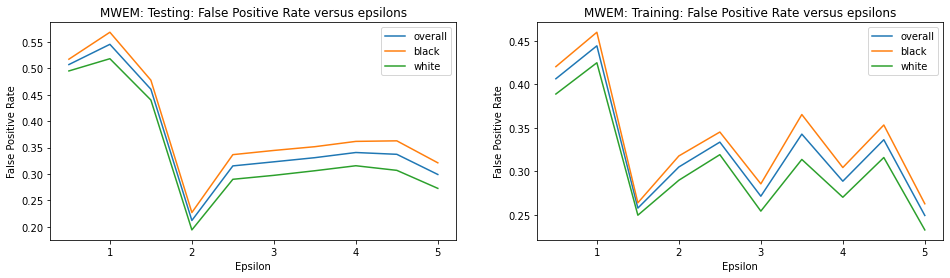

In [63]:
plotFPR("MWEM", test_results, train_results, epsilons)

In [75]:
def plotAccuracy(synthesizer, test_results, train_results, epsilons):
  plt.plot(epsilons,[result[0][4] for result in test_results],label="testing")
  plt.plot(epsilons,[result[0][4] for result in train_results],label="training")
  plt.legend()
  plt.title(synthesizer +": Accuracy versus epsilons")
  plt.ylabel("Accuracy")
  plt.xlabel("Epsilon")


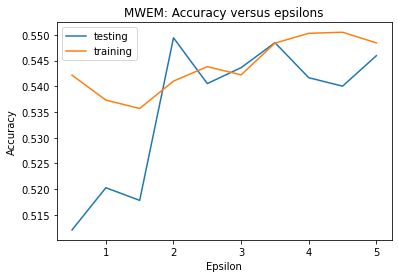

In [76]:
plotAccuracy("MWEM", test_results, train_results, epsilons)

In [81]:
def plotEqualizedOdds(synthesizer, test_results, train_results, epsilons):
  f = plt.figure(figsize=(16,4))
  ax = f.add_subplot(121)
  ax2 = f.add_subplot(122)
  plt.suptitle(synthesizer + ": Equalized odds distances versus epsilons")

  # black TPR - white TPR
  ax.plot(epsilons,[result[1][2]-result[2][2] for result in test_results],label="testing TPR diff")
  ax.plot(epsilons,[result[1][2]-result[2][2] for result in train_results],label="training TPR diff")
  ax.hlines(0,xmin=min(epsilons), xmax=max(epsilons),label="perfect fairness",linestyles="--")
  ax.hlines(0.24133825777,xmin=min(epsilons), xmax=max(epsilons),label="non-private TPR diff",linestyles="--",color="red")
  ax.legend()
  ax.set_xlabel("Epsilon")
  ax.set_ylabel("Equalized odds distance")
  ax.set_title(synthesizer + ": (TPR) Equalized odds distances versus epsilons")

  # black FPR - white FPR
  ax2.plot(epsilons,[result[1][0]-result[2][0] for result in test_results],label="testing FPR diff")
  ax2.plot(epsilons,[result[1][0]-result[2][0] for result in train_results],label="training FPR diff")
  ax2.hlines(0,xmin=min(epsilons), xmax=max(epsilons),label="perfect fairness",linestyles="--")
  ax2.hlines(0.13450471332,xmin=min(epsilons), xmax=max(epsilons),label="non-private FPR diff",linestyles="--",color="red")
  ax2.legend()
  ax2.set_xlabel("Epsilon")
  ax2.set_ylabel("Equalized odds distance")
  ax2.set_title(synthesizer + ": (FPT) Equalized odds distances versus epsilons")


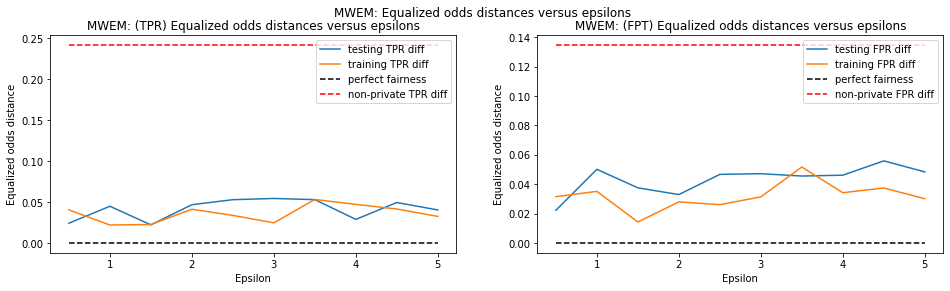

In [84]:
plotEqualizedOdds("MWEM", test_results, train_results, epsilons)


### **QUAIL**

In [90]:
epsilons = list(range(1,6))
try:
    # Try to load the dictionary with ten repetitions
    COMPAS_fairness_QUAIL = np.load("COMPAS_fairness_QUAIL.npy", allow_pickle=True).item()
    train_results, test_results = COMPAS_fairness_QUAIL["train_results"], COMPAS_fairness_QUAIL["test_results"]
except: 
    test_results, train_results = synthesizer(train_data, test_data, x_test, y_test, epsilons, niteration = 15, synthesizer="QUAIL")
    np.save("COMPAS_fairness_QUAIL.npy", {"train_results": train_results, "test_results": test_results})

print(test_results, train_results)

[[[0.41419647927314035, 0.47121535181236673, 0.5287846481876333, 0.5858035207268597, 0.5604797979797981], [0.44200626959247646, 0.42662266226622664, 0.5733773377337734, 0.5579937304075234, 0.5654876741693461], [0.38109452736318405, 0.5526104417670683, 0.44738955823293164, 0.6189054726368158, 0.5533026113671274]], [[0.43725156161272, 0.41961620469083155, 0.5803837953091685, 0.56274843838728, 0.570580808080808], [0.4898641588296761, 0.36435643564356435, 0.6356435643564358, 0.510135841170324, 0.5712754555198285], [0.3746268656716418, 0.5204819277108433, 0.4795180722891566, 0.6253731343283582, 0.5695852534562212]], [[0.3978421351504827, 0.4678038379530917, 0.5321961620469082, 0.6021578648495175, 0.5710858585858587], [0.44535005224660396, 0.4030803080308031, 0.5969196919691969, 0.5546499477533959, 0.5752411575562701], [0.3412935323383085, 0.5859437751004016, 0.41405622489959837, 0.6587064676616915, 0.5651305683563749]], [[0.3140261215218626, 0.5012082444918265, 0.49879175550817345, 0.685973

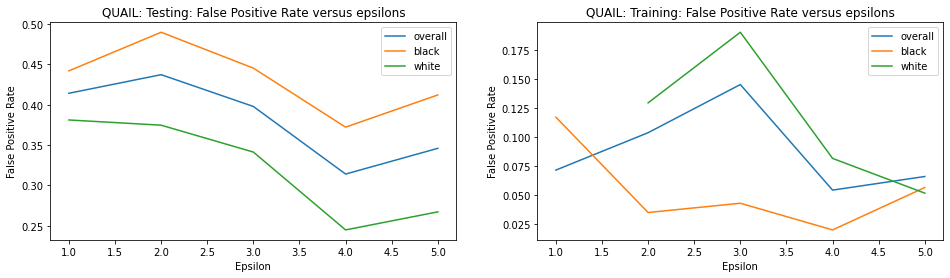

In [91]:
plotFPR("QUAIL", test_results, train_results, epsilons)

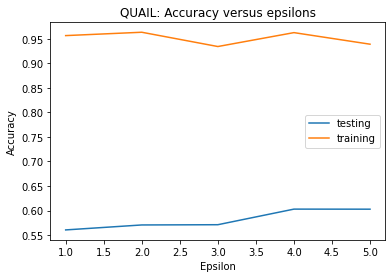

In [92]:
plotAccuracy("QUAIL", test_results, train_results, epsilons)

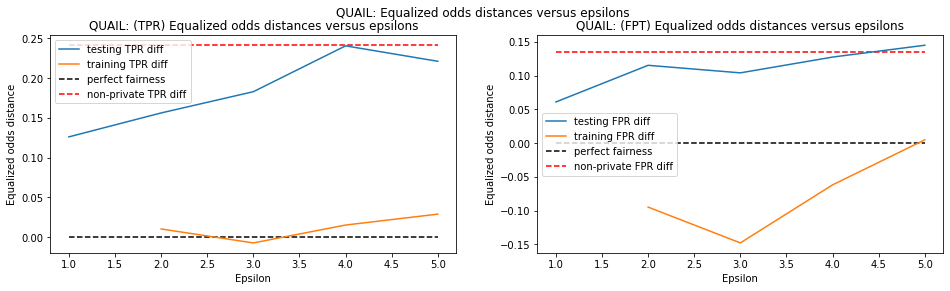

In [93]:
plotEqualizedOdds("QUAIL", test_results, train_results, epsilons)


In [97]:

# with 0.5 per iteration
epsilons = list(np.arange(1,6,0.5))

try:
    # Try to load the dictionary with ten repetitions
    COMPAS_fairness_QUAIL = np.load("COMPAS_fairness_QUAIL_2.npy", allow_pickle=True).item()
    train_results, test_results = COMPAS_fairness_QUAIL["train_results"], COMPAS_fairness_QUAIL["test_results"]
except: 
    test_results, train_results = synthesizer(train_data, test_data, x_test, y_test, epsilons, niteration = 15, synthesizer="QUAIL")
    np.save("COMPAS_fairness_QUAIL_2.npy", {"train_results": train_results, "test_results": test_results})

print(test_results, train_results)

[[[0.4385008517887564, 0.45088841506751953, 0.5491115849324805, 0.5614991482112436, 0.5559974747474746], [0.47398119122257065, 0.4125412541254125, 0.5874587458745875, 0.5260188087774293, 0.5559485530546624], [0.39626865671641787, 0.5208835341365462, 0.4791164658634538, 0.6037313432835821, 0.556067588325653]], [[0.44111300397501424, 0.42132196162046914, 0.578678038379531, 0.5588869960249858, 0.5676767676767677], [0.5011494252873563, 0.3623762376237624, 0.6376237623762377, 0.49885057471264366, 0.5664523043944265], [0.3696517412935324, 0.5289156626506025, 0.47108433734939764, 0.6303482587064676, 0.5694316436251919]], [[0.37319704713231105, 0.45444207533759773, 0.5455579246624023, 0.6268029528676888, 0.5907196969696967], [0.4309299895506792, 0.37667766776677664, 0.6233223322332234, 0.5690700104493208, 0.5954983922829583], [0.30447761194029854, 0.5963855421686747, 0.40361445783132527, 0.6955223880597017, 0.5838709677419355]], [[0.4180579216354344, 0.4686567164179104, 0.5313432835820895, 0.5

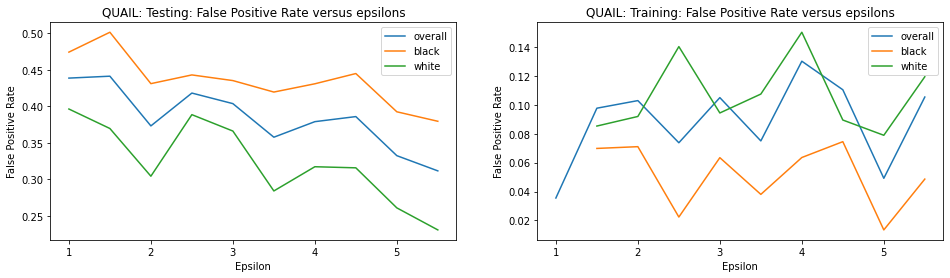

In [98]:
plotFPR("QUAIL", test_results, train_results, epsilons)

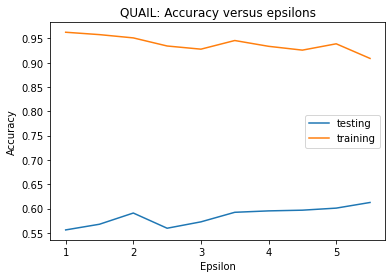

In [99]:
plotAccuracy("QUAIL", test_results, train_results, epsilons)

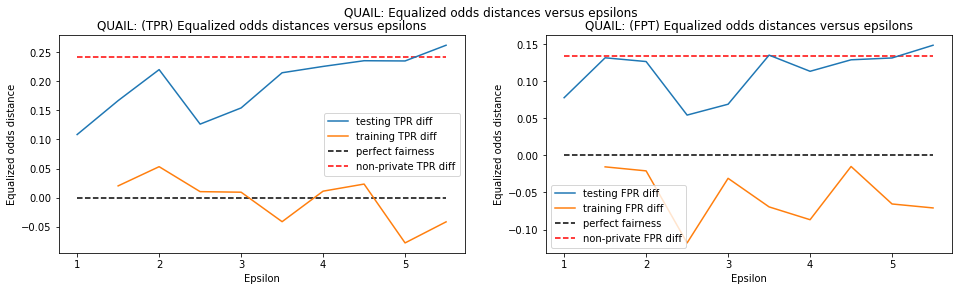

In [100]:
plotEqualizedOdds("QUAIL", test_results, train_results, epsilons)
